# Tif --> npy(image, label)

In [ ]:
import rasterio
import numpy as np

# TIF 파일 경로
tif_file_path = 'C:\\flood_data\\train1.tif'

# TIF 파일 열기
with rasterio.open(tif_file_path) as src:
    # 첫 번째 밴드 (Band 1)를 읽어와 img_1.npy로 저장
    band1 = src.read(1)  # Band 1
    np.save('img_1.npy', band1)
    
    # 두 번째 밴드 (Band 2)를 읽어와 label_1.npy로 저장
    band2 = src.read(2)  # Band 2
    np.save('label_1.npy', band2)

# 저장된 npy 파일들을 확인할 수 있습니다.
print("Band 1 saved as img_1.npy")
print("Band 2 saved as label_1.npy")

# Make Label smooth

In [ ]:
from scipy.ndimage import generic_filter
import numpy as np


labels = np.load('label_1.npy')

def smooth_edges(arr):
    # 주변 픽셀 중 1의 비율이 0.5 이상이면 1, 그렇지 않으면 0
    return 1 if np.sum(arr) / len(arr) > 0.5 else 0

# 3x3 필터를 적용하여 경계 매끄럽게
smoothed_labels = generic_filter(labels, smooth_edges, size=(10, 10))

# 결과 저장
np.save('smoothed_labels.npy', smoothed_labels)



"""import matplotlib.pyplot as plt

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Labels')
plt.imshow(labels, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Smoothed Labels')
plt.imshow(smoothed_labels, cmap='gray')
plt.show()"""

In [2]:
import numpy as np
import time
from itertools import compress
from skimage.util.shape import view_as_windows
import os
import matplotlib.pyplot as plt
import random
import json

# Load Pre_processed

In [3]:
image_path = "C:/flood_data/img_1.npy"
mask_path = "C:/flood_data/smoothed_labels.npy"
image = np.load(image_path)
mask = np.load(mask_path)

print(f"image shape: {image.shape}")
print(f"mask shape: {mask.shape}")

image shape: (21424, 35510)
mask shape: (21424, 35510)


In [4]:
# 'thebe' 폴더 및 하위 폴더 생성
os.makedirs('thebe/image', exist_ok=True)
os.makedirs('thebe/mask', exist_ok=True)

# Patch Params 

In [5]:
# 패치화 매개변수 설정
params = {
    "patch_size": (128, 128),  # 패치 크기
    "stride": (128, 128),      # 스트라이드
    "threshold": 0.1            # 필터링 기준 (유의미한 라벨 비율)
}
json_path = os.path.join('thebe', 'patch_params.json')
# JSON 파일로 저장
with open(json_path, 'w') as json_file:
    json.dump(params, json_file, indent=4)

print("패치화 매개변수가 'patch_params.json'에 저장되었습니다.")

패치화 매개변수가 'patch_params.json'에 저장되었습니다.


# MAKE PATCHES

In [6]:
start_time = time.time()

# 이미지와 마스크 패치화
image_patches = view_as_windows(image, params["patch_size"], step=params["stride"])
mask_patches = view_as_windows(mask, params["patch_size"], step=params["stride"])

# 각 패치에 대해 필터링 함수 정의
def filter_patches(mask_patch, threshold=0.1):
    return np.mean(mask_patch) > threshold  # 유의미한 라벨 비율 기준

# 이미지 패치와 마스크 패치 reshaping
image_patches_reshaped = image_patches.reshape(-1, params["patch_size"][0], params["patch_size"][1])
mask_patches_reshaped = mask_patches.reshape(-1, params["patch_size"][0], params["patch_size"][1])

# 유효한 패치 필터링
valid_patches = [
    (image_patch, mask_patch) 
    for image_patch, mask_patch in zip(image_patches_reshaped, mask_patches_reshaped)
    if filter_patches(mask_patch, params["threshold"])
]

end_time = time.time()

print(f"Total valid image patches: {len(valid_patches)}")
print(f"Processing time: {end_time - start_time} seconds")

# 'thebe' 폴더 및 하위 폴더 생성
os.makedirs('thebe/image', exist_ok=True)
os.makedirs('thebe/mask', exist_ok=True)

# 필터링된 이미지 패치와 마스크 저장
for i, (image_patch, mask_patch) in enumerate(valid_patches):
    np.save(f'thebe/image/valid_image_patch_{i}.npy', image_patch)
    np.save(f'thebe/mask/valid_mask_patch_{i}.npy', mask_patch)

Total valid image patches: 4873
Processing time: 49.864771366119385 seconds


# RANDOM PLOT

In [7]:
def plot_random_patches(valid_patches, num_samples=5):
    plt.figure(figsize=(15, 10))
    random_indices = random.sample(range(len(valid_patches)), num_samples)

    for i, idx in enumerate(random_indices):
        image_patch, mask_patch = valid_patches[idx]
        
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image_patch, cmap='gray')
        plt.title(f'Image Patch {idx}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask_patch, cmap='gray')
        plt.title(f'Mask Patch {idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

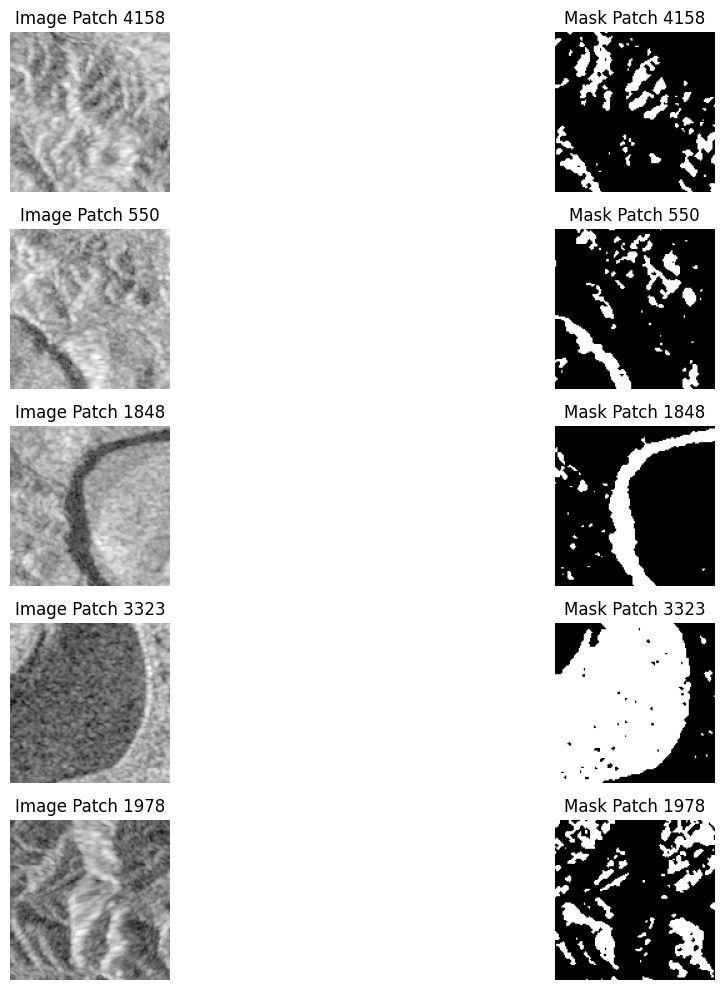

In [15]:
plot_random_patches(valid_patches, num_samples=5)